## Model selection

### Topics

Out of scope: [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering); we assume we already have good enough features.

1. Separate out training and validation sets from available data.

1. For each of the classification model families of logistic regression, decision trees, random forests and causal random forests, 

* fit the training data 

In [1]:
import os
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from fake_data_for_learning.contingency_tables import calculate_contingency_table

from risk_learning.simpson import (
    get_flat_combinations, 
    make_feature_combination_score_array,
    compute_margin
)

In [2]:
data_dir = Path(os.getcwd()) / 'data'

file_read_params = dict(delimiter=',')
target_col = 'default'
non_target_cols = ['gender', 'occupation', 'activity']
#non_target_cols = ['gender']
default = pd.read_csv(
    data_dir / 'default.csv', **file_read_params,
    usecols=non_target_cols + [target_col]
)
print(f'Shape of entire dataset: {default.shape}')
default.head()

Shape of entire dataset: (10000, 4)


,gender,occupation,activity,default
0,0,0,1,1
1,0,0,0,0
2,1,1,0,1
3,0,1,0,0
4,1,1,1,0


## Split data for model fitting

In [3]:
train_ratio = 0.6
validate_ratio_after_train_split = 0.5
seed = 42
X_train, X_validate_test, y_train, y_validate_test = train_test_split(
    default[non_target_cols], default[target_col], 
    train_size=train_ratio, random_state=seed
)
print(f'Shape of training fields: {X_train.shape},\nShape of target: {y_train.shape}')

X_validate, _, y_validate, _ = train_test_split(
    X_validate_test, y_validate_test, 
    train_size = validate_ratio_after_train_split, random_state=seed
)
print(f'\nShape of validation fields: {X_validate.shape},\nShape of target: {y_validate.shape}')

Shape of training fields: (6000, 3),
Shape of target: (6000,)

Shape of validation fields: (2000, 3),
Shape of target: (2000,)


### A little Exploratory Data Analysis

Very little.

In [4]:
# Value ranges can be guessed from data or extracted from IT system
default_values = [0, 1]
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
data_categories = dict(
    default=CategoricalDtype(categories=default_values, ordered=True),
    gender=CategoricalDtype(categories=gender_values, ordered=True),
    occupation=CategoricalDtype(categories=occupation_values, ordered=True),
    activity=CategoricalDtype(categories=activity_values, ordered=True)
)

# Recombine 
X_y_train = X_train.copy()
X_y_train['default'] = y_train.values
for column, c_type in data_categories.items():
    X_y_train[column] = X_y_train[column].astype(c_type)
    
contingency_table = calculate_contingency_table(X_y_train[data_categories.keys()])

In [5]:
female_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=0 )) 
    / compute_margin(contingency_table, dict(gender=0))
)
print('\nfemale empirical default rate', female_default_rate)
male_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=1)) 
    / compute_margin(contingency_table, dict(gender=1))
)
print('male empirical default rate', male_default_rate)


female empirical default rate 0.4040980853207927
male empirical default rate 0.3149189546807807


In [6]:
pairs = [('gender', 'default'), ('activity', 'default'), ('occupation', 'activity')]
for pair in pairs:
    print(f'Correlation of {pair}: {pearsonr(X_y_train[pair[0]], X_y_train[pair[1]])}')

Correlation of ('gender', 'default'): (-0.09293941102062706, 5.466334299546439e-13)
Correlation of ('activity', 'default'): (0.007885212957108069, 0.5414192607558002)
Correlation of ('occupation', 'activity'): (0.12700560772648403, 5.302043468524117e-23)


In [7]:
# Other variables uses when evaluating different models
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
feature_coords = dict(
    gender=gender_values,
    occupation=occupation_values,
    activity=activity_values
)
feature_combinations = get_flat_combinations(feature_coords)

## Fit models to training data and spot-check on validation data

In [8]:
first_n = 5
idxes_first_n = X_validate.index[:first_n]
X_validate_first_n = X_validate.loc[idxes_first_n, :]
y_validate_first_n = y_validate[:first_n]
sample_validate = X_validate_first_n.copy()
sample_validate['default'] = y_validate_first_n
sample_validate

,gender,occupation,activity,default
8113,1,0,0,1
1562,1,0,0,1
5735,0,1,0,0
9834,0,0,0,0
5379,0,1,0,0


## Logistic regression

In [9]:
hyperparams = {"C": 0.5, "random_state": 42}
clf = LogisticRegression(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.55218523, 0.44781477],
       [0.55218523, 0.44781477],
       [0.76667211, 0.23332789],
       [0.56295284, 0.43704716],
       [0.76667211, 0.23332789]])

In [10]:
# Choose non-default decision threshold as mean of default=1 probabilities
# NOTE choosing a good decision threshold deserves more attention than given here
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
threshold = np.mean(default_scores)
default_predict = default_scores > threshold
default_predict

array([ True,  True, False, ..., False,  True,  True])

In [11]:
precision_score(y_validate, default_predict)

0.47129909365558914

In [12]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(**dict(gender=0)).mean().values
mean_male_score = score_array.sel(**dict(gender=1)).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.linear_model._logistic.LogisticRegression'> mean scores
female: 0.35102134637759086, male: 0.3605350669609611


## Decision tree

In [13]:
hyperparams = {"criterion": "gini", "random_state": 42}
clf = DecisionTreeClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.04123711, 0.95876289],
       [0.04123711, 0.95876289],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [14]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
threshold = np.mean(default_scores)
default_predict = default_scores > threshold
default_predict

array([ True,  True, False, ...,  True, False, False])

In [15]:
precision_score(y_validate, default_predict)

0.9458064516129032

In [16]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(**dict(gender=0)).mean().values
mean_male_score = score_array.sel(**dict(gender=1)).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.tree._classes.DecisionTreeClassifier'> mean scores
female: 0.47500958662474113, male: 0.4817608385109203


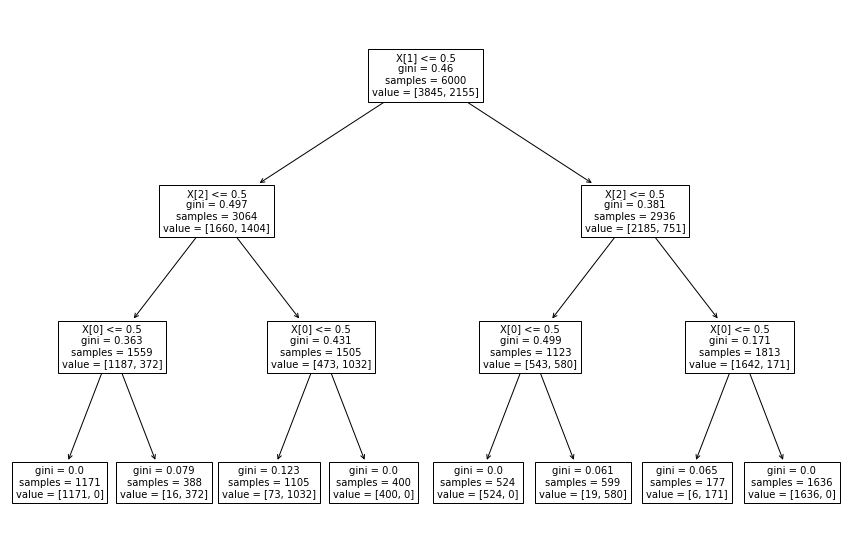

In [17]:
plt.figure(num=None,figsize=(15,10))
tree.plot_tree(clf, fontsize=10)
plt.show()

### Random Forest Classifier

In [18]:
hyperparams = {"n_estimators": 5, "random_state": 42}
clf = RandomForestClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.04098946, 0.95901054],
       [0.04098946, 0.95901054],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [19]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
threshold = np.mean(default_scores)
default_predict = default_scores > threshold
default_predict

array([ True,  True, False, ...,  True, False, False])

In [20]:
precision_score(y_validate, default_predict)

0.9458064516129032

In [21]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(**dict(gender=0)).mean().values
mean_male_score = score_array.sel(**dict(gender=1)).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.ensemble._forest.RandomForestClassifier'> mean scores
female: 0.47652312491135185, male: 0.48315441277037174
